In [22]:
import pyro
import torch
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import datetime

plt.style.use('ggplot')

In [2]:
parameters = {
    "30-34":{
        "conception":0.16,
        "miscarriage":0.108,
        "stillbirth":0.0034,
    },
    "35-39":{
        "conception":0.11,
        "miscarriage":0.167,
        "stillbirth":0.0040,
    },
    "40-44": {
        "conception":0.06,
        "miscarriage":0.332,
        "stillbirth":0.053,
    },
}

In [3]:
def attempt(params, t=0):
    days_to_conception = pyro.distributions.Geometric(params["conception"]).sample() * 28
    miscarriage = pyro.distributions.Bernoulli(params["miscarriage"]).sample()
    stillborn = pyro.distributions.Bernoulli(params["stillbirth"]).sample()
    if miscarriage.item() == 1 or stillborn == 1:
        days_to_conception = attempt(params, days_to_conception+t)
    gestation_days = pyro.distributions.Normal(280, 16).sample().item()
    day_of_menstruation = days_to_conception - 14
    return gestation_days + day_of_menstruation

In [4]:
simulations=10000
results = {}
for age,params in parameters.items():
    days = []
    for _ in range(simulations):
        days.append(attempt(params).item())
    results[age] = days

              30-34         35-39         40-44
count  10000.000000  10000.000000  10000.000000
mean     450.882516    547.239988    863.156599
std      196.841464    272.979674    519.028077
min      211.535065    213.055450    210.804352
25%      306.307404    340.383072    483.865952
50%      387.293137    478.336990    738.018250
75%      542.532028    668.067398   1104.539886
max     1954.566650   2384.962402   4495.518555


Text(0.5, 1.0, 'Probability of birth before a given day (CDF)')

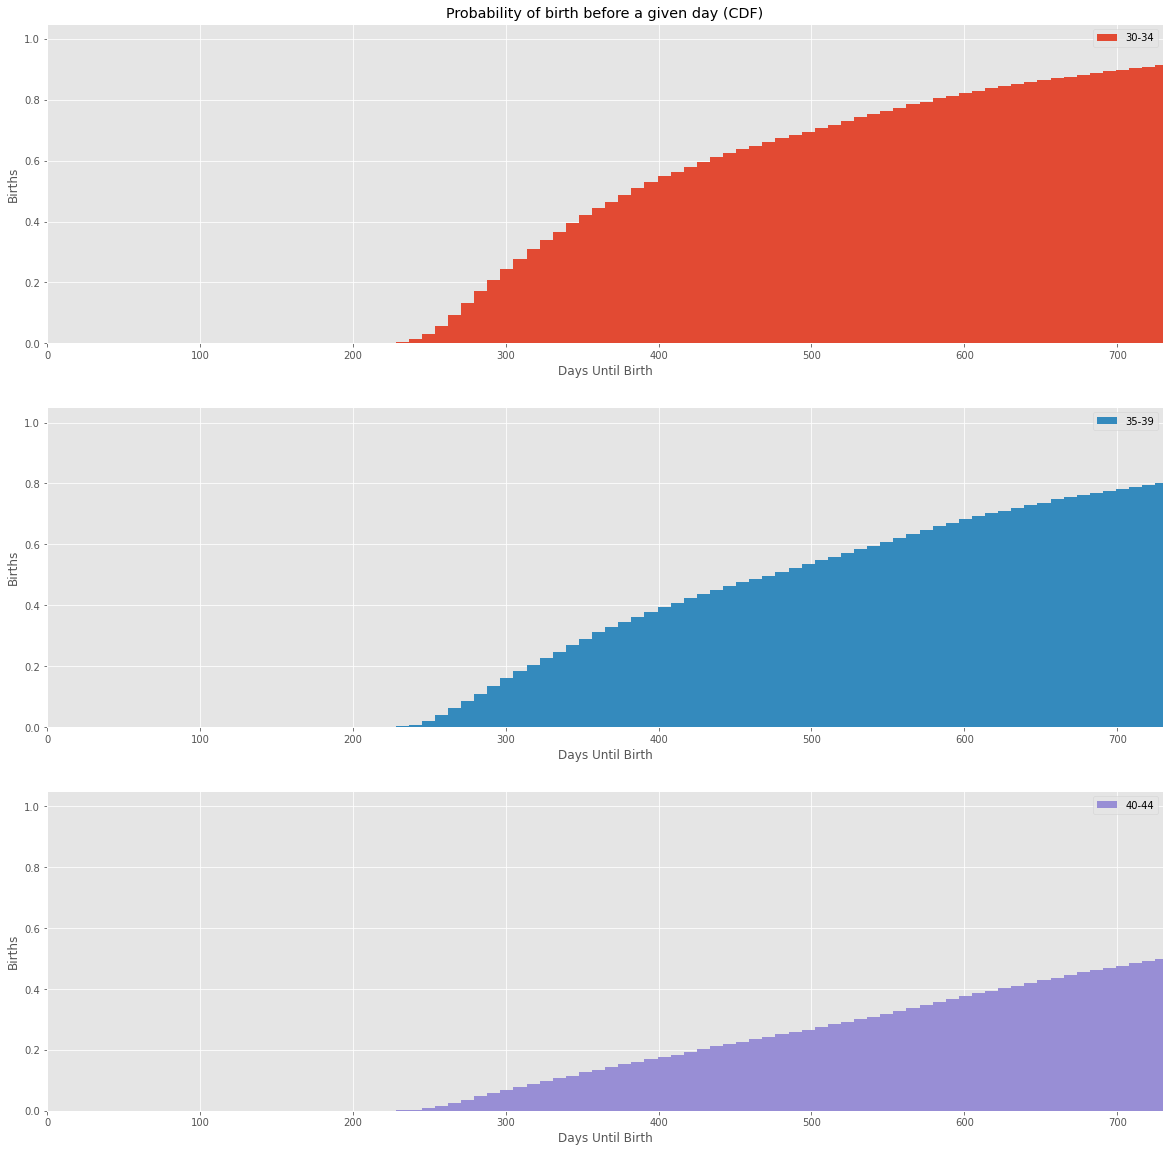

In [5]:
days_df = pd.DataFrame(results)
print(days_df.describe())
axes = days_df.plot(
    kind='hist',
    figsize=(20,20),
    bins=500,
    xlim=(0,365*2),
    subplots=True,
    sharey=True,
    sharex=False,
    cumulative=True,
    density=True,
)
for ax in axes:
    ax.set_xlabel("Days Until Birth")
    ax.set_ylabel("Births")
    
axes[0].set_title(f"Probability of birth before a given day (CDF)")

Text(0.5, 1.0, 'Number of birth on a given day out of 10,000 simulations')

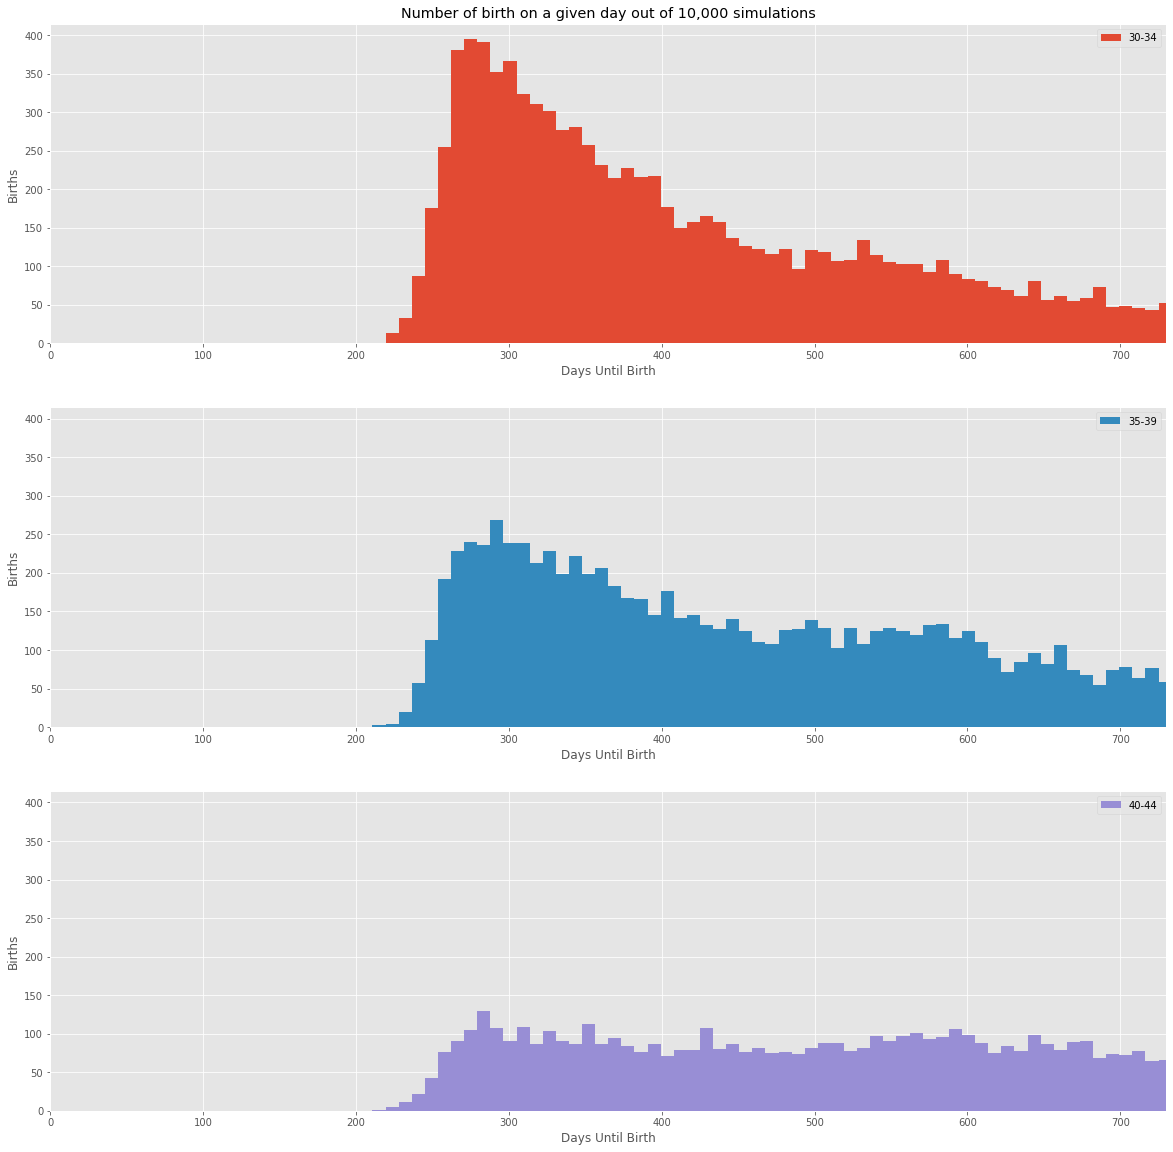

In [7]:
axes = days_df.plot(
    kind='hist',
    figsize=(20,20),
    bins=500,
    xlim=(0,365*2),
    subplots=True,
    sharey=True,
    sharex=False,
)
for ax in axes:
    ax.set_xlabel("Days Until Birth")
    ax.set_ylabel("Births")
    
axes[0].set_title(f"Number of birth on a given day out of {simulations:,} simulations")

In [32]:
ovulation = datetime.date(2020,9,12)
p25_date = ovulation + datetime.timedelta(days = days_df['30-34'].quantile(0.25))
p75_date = ovulation + datetime.timedelta(days = days_df['30-34'].quantile(0.75))

print(f"25th percentile date: {p25_date}")
print(f"75th percentile date: {p75_date}")

25th percentile date: 2021-07-15
75th percentile date: 2022-03-08
